Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Tutorial 3 "
COLLABORATORS = "Aakash Rajpal"

---

# 4. Inifnite Categorical Mixture Model + Gibbs Sampling

In [2]:
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd

from categorical_gibbs_bnp import CategoricalGibbsBNP

##  Hyperparameters



In [3]:
## 1. Hyperparameters
I = 120
N = None

## Load and preprocess the data

In [4]:
df = pd.read_csv('../../tweets_cleaned.csv')
# df = df.head(800)
# df = df.head(800)
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval)
X_tokens = list(df['tokens'].values)
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

I = len(dictionary)
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(X_bow)

X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]

### Exercise 1: Analytical forms of different Gibbs sampling algorithms

1. Algorithm 1

1. $p(Z_{n} = k | X,Z_{-n}, \theta)$

Here we can have two different cases\
i) New cluster k\
ii) No new cluster\
For both cases\
$p(Z_{n} = k | X,Z_{-n}, \theta) \propto p(Z_{n}, X_{n} | Z_{-n}, \theta)$

$ = p(X_{n} | Z_{n} = k, Z_{-n}, \theta) p(Z_{n} = k | Z_{-n})$

Now we will compute $p(Z_{n} = k | Z_{-n})$ for both the cases\

$p(Z_{n} = k | Z_{-n}) = \frac{\sum_{i \neq n}^{n} [ Z_{i} = k ] + \alpha_{k}}{N - 1 + \sum_{k} \alpha_{k} }$

As we consider infinite clusters the Dirichlet parameters are $\alpha/k$ so $\sum_{k} \alpha_k$ becomes $\alpha$\
and also we define $m_{k}(n)$ depicting the number of samples in cluster k.

We know that $\sum_{k = 1}^{\infty} p(Z_{n} = k | Z_{-n}) = 1$ as the probabilities of assigning a sample across different clusters has to sum to 1.\
Or,

$\lim_{K \to \infty} \sum_{k = 1}^{K} \frac{m_{k}(n) + \alpha/K}{N - 1 + \alpha} = 1$

$\lim_{K \to \infty} \sum_{k = 1}^{K^{+}} \frac{m_{k}(n) + \alpha/K}{N - 1 + \alpha} + \lim_{K \to \infty} \sum_{k = K^{+}}^{K} \frac{\alpha/K}{N - 1 + \alpha} = 1$

$\frac{m_{k}(n)}{N - 1 + \alpha} + \cdots\cdots = 1$

$p(Z_{n} = k_{new} | Z_{-n}) = 1 - \frac{N - 1}{N - 1 + \alpha} = \frac{\alpha}{N - 1 + \alpha}$

Now we have computed $p(Z_{n} = k | Z_{-n})$ for both cases\
i) New cluster k $\frac{\alpha}{N - 1 + \alpha}$\
ii) No new cluster $\frac{m_{k}(n)}{N - 1 + \alpha}$

Now to compute the second component $p(X_{n} | Z_{n} = k, Z_{-n}, \theta)$ for both the cases\
i)No new cluster\
$p(X_{n} | Z_{n} = k, Z_{-n}, \theta) = p(X_{n} | \theta_{k})$

ii) New cluster k\
$p(X_{n} | Z_{n} = k, Z_{-n}, \theta) = p(X_{n} | Z_{n} = k_{new})$

$ = \int p(X_{n}, \theta | Z_{n} = k_{new}) d\theta$\
$ = \int p(X_{n} | Z_{n} = k_{new}, \theta) p(\theta) d\theta$\
$ = \int p(X_{n} | \theta) Dir(\theta | \gamma ) d\theta$\
$ = \int \prod_{j = 1}^{W_{n}} \prod_{m = 1}^{|I|} \theta_{m}^{[X_{nj} = m]} \frac{1}{\beta(\gamma)}\prod_{m = 1}^{|I|} \theta_{m}^{\gamma_{m} - 1}$

$c_{m} = \sum_{j} [X_{nj} = m]$

$ = \int \prod_{m = 1}^{|I|} \theta_{m}^{c_{m}} \frac{1}{\beta(\gamma)}\prod_{m = 1}^{|I|} \theta_{m}^{\gamma_{m} - 1}$

$\frac{1}{\beta(\gamma)} \int \prod_{m = 1}^{|I|} \theta_{m}^{\gamma_{m} + c_{m} + - 1} d\theta$

Considering $\gamma_{m}^{'} = \gamma_{m} + c_m$

$ = \frac{\beta(\gamma^{'})}{\beta(\gamma)} \int \frac{1}{\beta(\gamma^{'})}  \prod_{m = 1}^{|I|} \theta_{m}^{\gamma_{m} + c_{m} + - 1} d\theta$

$ = \frac{\beta(\gamma^{'})}{\beta(\gamma)} \int Dir(\gamma^{'}) d\theta$

$ = \frac{\beta(\gamma^{'})}{\beta(\gamma)}$

finally 
i) New cluster k\
$p(Z_{n} = k | X,Z_{-n}, \theta) = \frac{\alpha}{N - 1 + \alpha} \frac{\beta(\gamma^{'})}{\beta(\gamma)} $

ii) No new cluster\
$p(Z_{n} = k | X,Z_{-n}, \theta) = \frac{m_{k}(n)}{N - 1 + \alpha} p(X_n | \theta_{k})$

3. $p(\theta_{k} | X, Z)$

$p(\theta_{k} | X, Z) \propto p(\theta_{k}, X | Z)$\
$ = p(\theta_{k} | \gamma) p(X|\theta_{k}, Z)$\
$ = Dir(\theta_k | \gamma) \prod_{n}^{N} \prod_{j}^{W_{n}} Cat(X_{nj} | \theta_{k})^{[Z_{n} = k]}$\
$ = Dir(\theta_k | \gamma) \prod_{n}^{N} \prod_{j}^{W_{n}} \prod_{m}^{|I|} Cat(X_{nj} | \theta_{k})^{[Z_{n} = k][X_{nj} = m]}$

Consider $c_{km} = \sum_{n} \sum_{j} [Z_{n} = k][X_{nj} = m]$\
$ = Dir(\theta_k | \gamma) \prod_{m}^{|I|}  \theta_{km})^{c_{km}}$

$ = Dir(\theta_k | \{\gamma_{m} + c_{km}\})$

2. $p(\theta_{k} | X_{n})$

Considering the previous proof here\
$c_{km}^{'} = \sum_{j} [X_{nj} = m]$ will be defined like this rest will be same\
So the final distribution will be\

$ = Dir(\theta_k | \{\gamma_{m} + c_{km}^{'}\})$








1. Algorithm 2

1. $p(Z_{n} | X, Z_{-n})$\
Here as well we need to consider two cases\
i) No new cluster\
$p(Z_{n} | X, Z_{-n}) \propto p(Z_{n} = k, X_{n} | Z_{-n}) $\
$p(X_{n} | Z_{n} = k, Z_{-n}, X_{-n}) p(Z_{n} = k | Z_{-n})$\

Now $p(Z_{n} = k | Z_{-n})$ we have already computed in Algo 1\
$p(Z_{n} = k | Z_{-n}) = \frac{m_{k}(n)}{N - 1 + \alpha}$

Hence,\
$ = p(X_{n} | Z_{n} = k, Z_{-n}, X_{-n}) \frac{m_{k}(n)}{N - 1 + \alpha}$\

Now Considering $p(X_{n} | Z_{n} = k, Z_{-n}, X_{-n})$

$ = \int p(X_{n}, \theta_{k} | Z_{n} = k, Z_{-n}, X_{-n}) d\theta_{k}$\
$ = \int p(X_{n}| Z_{n} = k, \theta_{k}) p (\theta_{k} | Z_{-n}, X_{-n}) d\theta_{k}$\

Now first we will consider $p (\theta_{k} | Z_{-n}, X_{-n})$ as we have already derived $p (\theta_{k} | Z, X)$ in Algo 1.\
We had $\sum_{n} \sum_{j} [Z_{n} = k][X_{nj} = m]$ in Algo but now we need to remove the nth sample,so\
Now defining $c_{km} = \sum_{i \neq n} \sum_{j} [Z_{i} = k][X_{ij} = m]$\

So $p (\theta_{k} | Z_{-n}, X_{-n}) = Dir(\theta_{k} | \{ \gamma_{m} + c_{km}\})$

$ = \int \prod_{m = 1}^{|I|} \theta_{k}^{d_{m}} Dir(\theta_{k} | \{ \gamma_{m} + c_{km}\}) d\theta_{k}$\
Here $d_{m} = \sum_{j} [X_{nj} = m]$

$ = \int \prod_{m = 1}^{|I|} \theta_{k}^{d_{m}} \frac{1}{\beta(\gamma^{'})} \prod_{m}^{|I|}\theta_{k}^{\gamma_{m}^{'} - 1} d\theta_{k}$\

Here $\gamma^{'}  = \gamma_{m} + c_{km}$\
$ = \frac{1}{\beta(\gamma^{'})} \int \prod_{m}^{\gamma_{m}^{'} + d_{m} - 1} d\theta_{k}$\
$ = \frac{\beta(\gamma^{''})}{\beta(\gamma^{'})} \int Dir(\theta_{k} | \gamma^{''}) d\theta_{k}$\

Here $\gamma^{''}  = \gamma_{m}^{'} + d_{m}$\
$ = \frac{\beta(\gamma^{''})}{\beta(\gamma^{'})}$

Final $p(Z_{n} | X, Z_{-n}) = \frac{m_{k}(n)}{N - 1 + \alpha} \frac{\beta(\gamma^{''})}{\beta(\gamma^{'})} $ for no new cluster.

ii) New cluster k

$p(X_{n} | Z_{n} = k, Z_{-n}, X_{-n}) p(Z_{n} = k | Z_{-n})$

Now $p(Z_{n} = k | Z_{-n})$ we have already computed in Algo 1\
$p(Z_{n} = k | Z_{-n}) = \frac{\alpha}{N - 1 + \alpha}$

Now for $p(X_{n} | Z_{n} = k, Z_{-n}, X_{-n}) = p(X_{n} | Z_{n} = k)$\
And this we have already computed in Algorithm 1 

$c_{m} = \sum_{j} [X_{nj} = m]$\
Considering $\gamma_{m}^{'} = \gamma_{m} + c_m$\
$p(X_{n} | Z_{n} = k) = \frac{\beta(\gamma^{'})}{\beta(\gamma)}$

So final $p(Z_{n} | X, Z_{-n}) = \frac{\beta(\gamma^{'})}{\beta(\gamma)} \frac{\alpha}{N - 1 + \alpha}$

## Create the model and train

In [5]:
model = CategoricalGibbsBNP(I, N, alpha=0.1, gamma_v=np.ones(I))
model.dictionary = dictionary

In [6]:
model.fit(X_matrix,  burn_in=50, iter=100, collapsed=1)

Using pi collapsed Gibbs sampling!
Adding a cluster! K_p: 2
Adding a cluster! K_p: 3
Adding a cluster! K_p: 4
Adding a cluster! K_p: 5
Adding a cluster! K_p: 6
Adding a cluster! K_p: 7
Adding a cluster! K_p: 8
Adding a cluster! K_p: 9
ITER: 0 | log_lik: -99707.55199565405
Adding a cluster! K_p: 10
Removing a cluster! K_p: 9
ITER: 10 | log_lik: -93504.40754567979
ITER: 20 | log_lik: -92482.53226820272
Adding a cluster! K_p: 10
Removing a cluster! K_p: 9
Adding a cluster! K_p: 10
Removing a cluster! K_p: 9
ITER: 30 | log_lik: -92279.87105295088
Adding a cluster! K_p: 10
ITER: 40 | log_lik: -92258.90697205895
Removing a cluster! K_p: 9
Adding a cluster! K_p: 10
Adding a cluster! K_p: 11
ITER: 50 | log_lik: -92263.60856295827
Adding a cluster! K_p: 12
Removing a cluster! K_p: 11
Removing a cluster! K_p: 10
Removing a cluster! K_p: 9
ITER: 60 | log_lik: -92076.19286637612
Adding a cluster! K_p: 10
ITER: 70 | log_lik: -92269.42720553764
Removing a cluster! K_p: 9
Adding a cluster! K_p: 10
IT

Text(0.5, 1.0, 'Pi collapsed Gibbs sampling')

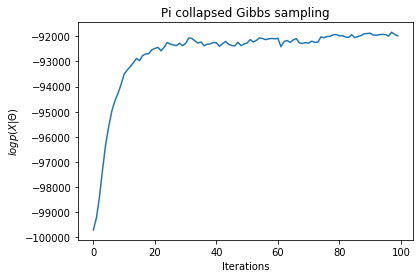

In [7]:
import matplotlib.pyplot as plt
data = plt.plot(model.log_px_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')
plt.title('Pi collapsed Gibbs sampling')

In [8]:
model = CategoricalGibbsBNP(I, N, alpha=0.1, gamma_v=np.ones(I))
model.dictionary = dictionary
model.fit(X_matrix,  burn_in=50, iter=100, collapsed=2)

Using Fully collapsed Gibbs sampling!
ITER: 0 | log_lik: -103080.9758709523
Adding a cluster! K_p: 2
ITER: 10 | log_lik: -102994.70387254676
Adding a cluster! K_p: 3
Removing a cluster! K_p: 2
ITER: 20 | log_lik: -101045.02674508236
Adding a cluster! K_p: 3
ITER: 30 | log_lik: -98783.49148756727
ITER: 40 | log_lik: -98061.04298876667
Adding a cluster! K_p: 4
Removing a cluster! K_p: 3
ITER: 50 | log_lik: -97981.5090172496
Adding a cluster! K_p: 4
Removing a cluster! K_p: 3
ITER: 60 | log_lik: -98018.12660144242
Adding a cluster! K_p: 4
Removing a cluster! K_p: 3
ITER: 70 | log_lik: -98007.01977752514
Adding a cluster! K_p: 4
Removing a cluster! K_p: 3
Adding a cluster! K_p: 4
Removing a cluster! K_p: 3
ITER: 80 | log_lik: -98034.50320007178
Adding a cluster! K_p: 4
ITER: 90 | log_lik: -98050.1660900778


Text(0.5, 1.0, 'Fully collapsed Gibbs sampling')

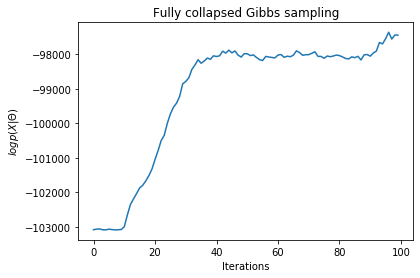

In [9]:
import matplotlib.pyplot as plt
data = plt.plot(model.log_px_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')
plt.title('Fully collapsed Gibbs sampling')

In [10]:
model.show_words_by_topic(dictionary, n_words=10)

Topic  0
time | book | share | day | work | net | new | complet | train | sha

Topic  1
year | new | great | look | today | thank | time | peopl | like | work

Topic  2
human | machin | data | paper | deep | model | work | research | new | learn

Topic  3
life | result | way | tri | woman | good | use | like | scienc | data



### Exercise 2: Inspect the code

#### Algorithm 1

In [11]:
# 1.
line_sample_z_n_given_  = 202 
# 2.
line_sample_theta_given_x_n  = 213
# 3.
line_sample_theta_k_given_X_Z =  183 
# 4.
code_remove_empty_cluster  =  [227, 235] 
#5.
code_add_new_cluster  =   [207, 215] 
# YOUR CODE HERE


In [12]:
print(f"{line_sample_z_n_given_} {line_sample_theta_given_x_n} {line_sample_theta_k_given_X_Z} {code_remove_empty_cluster} {code_add_new_cluster}")


202 213 183 [227, 235] [207, 215]


#### Algorithm 2


In [13]:
# 1. 
line_sample_z_n_given_  = 176 
# 2.
line_compute_zn_k_given_Zn = 165
# 3.
line_compute_zn_Knew_given_Zn  = 171 

In [14]:
print(f"{line_sample_z_n_given_} {line_compute_zn_k_given_Zn} {line_compute_zn_Knew_given_Zn}")

176 165 171


#### Other


In [15]:
# 1.
function_pxn_given_zn_Knew  = 'likelihood_xn_knew' 
# 2.
function_log_pX_given_Z_theta = 'log_likelihood_X' 
# 3.
init_seen_clusters  = 1

In [16]:
print(f"{function_pxn_given_zn_Knew} {function_log_pX_given_Z_theta} {init_seen_clusters}")

likelihood_xn_knew log_likelihood_X 1
